In [1]:
%%capture --no-stderr
!pip install -U langchain langchain_community pypdf sentence_transformers chromadb

In [5]:
import langchain, langchain_community, pypdf, sentence_transformers, chromadb

for module in (langchain, langchain_community, pypdf, sentence_transformers, chromadb):
    print(f"{module.__name__:<30}{module.__version__}")

langchain                     0.2.10
langchain_community           0.2.9
pypdf                         4.3.1
sentence_transformers         3.0.1
chromadb                      0.5.4


In [ ]:
import os
import pandas as pd

from langchain_community.vectorstores import Chroma

In [ ]:
# 如果已经下载到本地，可以替换为本地路径
EMBEDDING_MODEL_PATH = 'BAAI/bge-large-zh-v1.5'
dt = '20240713'
version = 'v1'

output_dir = os.path.join('outputs', f'{version}_{dt}')

# 读取文档

In [ ]:
from langchain_community.document_loaders import PyPDFLoader

In [ ]:
loader = PyPDFLoader("data/2024全球经济金融展望报告.pdf")
documents = loader.load()

In [ ]:
qa_df = pd.read_excel(os.path.join(output_dir, 'question_answer.xlsx'))

# 文档切分

In [ ]:
from uuid import uuid4
import os
import pickle

from langchain.text_splitter import RecursiveCharacterTextSplitter

def split_docs(documents, filepath, chunk_size=400, chunk_overlap=40, seperators=['\n\n\n', '\n\n'], force_split=False):
    if os.path.exists(filepath) and not force_split:
        print('found cache, restoring...')
        return pickle.load(open(filepath, 'rb'))

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=seperators
    )
    split_docs = splitter.split_documents(documents)
    for chunk in split_docs:
        chunk.metadata['uuid'] = str(uuid4())

    pickle.dump(split_docs, open(filepath, 'wb'))

    return split_docs

In [ ]:
splitted_docs = split_docs(documents, os.path.join(output_dir, 'split_docs.pkl'), chunk_size=500, chunk_overlap=50)

found cache, restoring...


# 检索

In [ ]:
from langchain.embeddings import HuggingFaceBgeEmbeddings
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

embeddings = HuggingFaceBgeEmbeddings(
    model_name=EMBEDDING_MODEL_PATH,
    model_kwargs={'device': device},
    encode_kwargs={'normalize_embeddings': True}
)

device: cpu


In [ ]:
from tqdm.auto import tqdm

def get_vector_db(docs, store_path, force_rebuild=False):
    if not os.path.exists(store_path):
        force_rebuild = True

    if force_rebuild:
        vector_db = Chroma.from_documents(
            docs,
            embedding=embeddings,
            persist_directory=store_path
        )
    else:
        vector_db = Chroma(
            persist_directory=store_path,
            embedding_function=embeddings
        )
    return vector_db

In [ ]:
def retrieve(vector_db, query: str, k=5):
    return vector_db.similarity_search(query, k=k)

In [ ]:
vector_db = get_vector_db(splitted_docs, store_path=os.path.join(output_dir, 'chromadb', 'bge_large_v1.5'))

## 计算检索准确率

In [ ]:
test_df = qa_df[(qa_df['dataset'] == 'test') & (qa_df['qa_type'] == 'detailed')]

In [ ]:
len(test_df)

93

In [ ]:
top_k_arr = list(range(1, 9))
hit_stat_data = []

for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
    question = row['question']
    true_uuid = row['uuid']
    chunks = retrieve(vector_db, question, k=max(top_k_arr))
    retrieved_uuids = [doc.metadata['uuid'] for doc in chunks]

    for k in top_k_arr:
        hit_stat_data.append({
            'question': question,
            'top_k': k,
            'hit': int(true_uuid in retrieved_uuids[:k])
        })

  0%|          | 0/93 [00:00<?, ?it/s]

In [ ]:
hit_stat_df = pd.DataFrame(hit_stat_data)

In [ ]:
hit_stat_df.sample(5)

,question,top_k,hit
606,海湾六国经济结构的主要问题是什么？,7,1
482,2023年瑞士法郎对美元的升值幅度是多少？,3,1
375,2024年预计新兴经济体的整体经济增速是多少？,8,1
562,美欧加大国债发行力度可能导致什么后果？,3,1
442,美联储在2月1日的基点变动了多少?,3,1


In [ ]:
import seaborn as sns

In [ ]:
hit_stat_df.groupby('top_k')['hit'].mean().reset_index()

,top_k,hit
0,1,0.462366
1,2,0.591398
2,3,0.688172
3,4,0.774194
4,5,0.806452
5,6,0.817204
6,7,0.838710
7,8,0.849462


<Axes: xlabel='top_k', ylabel='hit'>

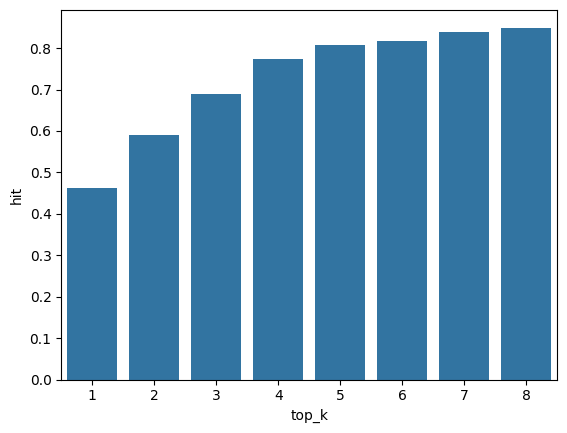

In [ ]:
sns.barplot(x='top_k', y='hit', data=hit_stat_df.groupby('top_k')['hit'].mean().reset_index())

# 生成答案

In [ ]:
from langchain.llms import Ollama

llm = Ollama(
    model='qwen2:7b-instruct',
    base_url="http://localhost:11434/v1"
)

In [ ]:
llm.invoke('你是谁')

'我是阿里云开发的一款超大规模语言模型，我叫通义千问。作为一个AI助手，我的目标是帮助用户获得准确、有用的信息，解决他们的问题和困惑。我可以回答各种领域的问题、提供信息查询、解释概念、提供建议等。请随时告诉我您需要什么帮助！'

In [ ]:
def rag(query, n_chunks=5):
    prompt_tmpl = """
你是一个金融分析师，擅长根据所获取的信息片段，对问题进行分析和推理。
你的任务是根据所获取的信息片段（<<<<context>>><<<</context>>>之间的内容）回答问题。
回答保持简洁，不必重复问题，不要要添加描述性解释和与答案无关的任何内容。
已知信息：
<<<<context>>>
{{knowledge}}
<<<</context>>>

问题：{{query}}
请回答：
""".strip()

    chunks = retrieve(vector_db, question, k=n_chunks)
    prompt = prompt_tmpl.replace('{{knowledge}}', '\n\n'.join([doc.page_content for doc in chunks])).replace('{{query}}', query)

    return llm(prompt), [doc.page_content for doc in chunks]

In [ ]:
prediction_df = qa_df[qa_df['dataset'] == 'test'][['uuid', 'question', 'qa_type', 'answer']]

answer_dict = {}

In [ ]:
for idx, row in tqdm(prediction_df.iterrows(), total=len(prediction_df)):
    uuid = row['uuid']
    question = row['question']
    answer, context = rag(question, n_chunks=4)
    answer_dict[question] = {
        'uuid': uuid,
        'ref_answer': row['answer'],
        'gen_answer': answer,
        'context': context
    }

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [ ]:
prediction_df.loc[:, 'gen_answer'] = prediction_df['question'].apply(lambda q: answer_dict[q]['gen_answer'])
prediction_df.loc[:, 'context'] = prediction_df['question'].apply(lambda q: answer_dict[q]['context'])

In [ ]:
prediction_df.sample(5)

,uuid,question,qa_type,answer,gen_answer,context
76,0943b71a-7314-4cef-a7d9-682c7ddc9d7f,2023年10月美国ISM制造业PMI指数较上月有何变化？,detailed,大幅下降2.3个百分点,2023年10月美国ISM制造业PMI指数较上个月大幅下降了2.3个百分点。,[全球经济金融展望报告\n中国银行研究院 10 2024年\n模下降2.5%，进口降幅大于出...
19,1f406690-b478-43cd-96f8-cd77924e300e,2023年三季度英国GDP环比增速是多少？,detailed,2023年三季度英国GDP环比增速下降0.03%。,2023年三季度英国GDP环比增速为-0.03%。,[全球经济金融展望报告\n中国银行研究院 13 2024年\n图9：欧元区GDP环比增速、综...
6,e73a0c9d-d42b-4350-a4c3-b38bf67c68a5,哪些热点问题在报告中被提及？,detailed,海湾六国经济发展与投资前景，高利率和高债务对美国房地产市场脆弱性的影响。,报告中提到的几个主要热点问题包括：\n\n1. **全球人工智能治理**：报告讨论了为解决人...,[全球经济金融展望报告\n中国银行研究院 20 2024年\n图13：部分亚洲新兴经济体GD...
296,873ee876-8549-49b9-b182-6584113b2701,目前美国居住房地产市场的市值余额是多少？,detailed,56.3万亿美元,根据报告中的信息，当前美国商业房地产市场中办公楼宇部分的资产余额连续四个季度上升至718亿美...,[全球经济金融展望报告\n中国银行研究院 48 2024年\n该类贷款新发放量将同比下降46...
180,a52f60d5-4430-405f-a2dd-8a975ac03b91,美国金融危机风险指标的英文缩写是什么？,detailed,ROFCI,美国金融危机风险指标的英文缩写是ROFCI（Risk of Financial Crisis...,[全球经济金融展望报告\n中国银行研究院 25 2024年\n图15：美联储资产规模变化（亿...
